# Выбор локации для скважины

# Введение

### Описание проекта 
Проект нацелен на определение места бурения новой скважины добывающей компании «ГлавРосГосНефть».
### Цель проекта
Построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски.
### Описание данных
**Нам предоставили данные геологоразведки трёх регионов.**   


В таблицах данных представлены следующие значения:  

**Признаки:**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

**Целевой признак:**
- product — объём запасов в скважине (тыс. баррелей).

### Условия задачи 


- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### План работы
1. [Загрузка и подготовка данных](#section_1)
2. [Обучение и проверка модели](#section_2)  
3. [Подготовка к расчёту прибыли](#section_3)  
4. [Рассчёт прибыли и рисков](#section_4)
5. [Общий вывод](#section_5)

<a id='section_1'></a>
## Загрузка и подготовка данных

### Изучение общей информации о данных

Загрузим необходимые библиотеки.

In [1]:
#!pip install pandas-profiling

In [2]:
# анализ данных
import pandas as pd
import numpy as np
from scipy import stats as st
#from pandas_profiling import ProfileReport

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# модель машинного обучения
from sklearn.linear_model import LinearRegression

# вспомогательные средства 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

Загрузим данные.

In [3]:
try:
    geo_data_0 = pd.read_csv(r'D:\projects_data\well_location\geo_data_0.csv')
    geo_data_1 = pd.read_csv(r'D:\projects_data\well_location\geo_data_1.csv')
    geo_data_2 = pd.read_csv(r'D:\projects_data\well_location\geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# настройка отображения графиков
sns.set(rc={'figure.figsize': (15,5)})

In [5]:
#geo_data_0.profile_report(title='Отчёт по данным скважин региона №0')

In [6]:
#geo_data_1.profile_report(title='Отчёт по данным скважин региона №1')

In [7]:
#geo_data_2.profile_report(title='Отчёт по данным скважин региона №2')

### Обработка дубликатов

In [8]:
display(geo_data_0['id'].nunique())
geo_data_0[geo_data_0['id'].duplicated()]

99990

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


В данных присутствуют дубликаты, от которых стоит избавиться.

In [9]:
geo_data_0 = geo_data_0[~geo_data_0['id'].duplicated()]
geo_data_1 = geo_data_1[~geo_data_1['id'].duplicated()]
geo_data_2 = geo_data_2[~geo_data_2['id'].duplicated()]

### Подготовка признаков

ID точки добычи не несёт необходимой информации для модели, поэтому отбросим этот столбец.

In [10]:
features_0 = geo_data_0.drop(['id','product'], axis=1)
target_0 = geo_data_0['product']

features_1 = geo_data_1.drop(['id','product'], axis=1)
target_1 = geo_data_1['product']

features_2 = geo_data_2.drop(['id','product'], axis=1)
target_2 = geo_data_2['product']

### Деление данных на выборки

In [11]:
X_0_train, X_0_valid, y_0_train, y_0_valid = train_test_split(features_0, target_0, test_size=0.25, random_state=0)
X_1_train, X_1_valid, y_1_train, y_1_valid = train_test_split(features_1, target_1, test_size=0.25, random_state=0)
X_2_train, X_2_valid, y_2_train, y_2_valid = train_test_split(features_2, target_2, test_size=0.25, random_state=0)

### Масштабирование признаков

In [12]:
scaler = StandardScaler()

# первый регион
scaler.fit(X_0_train)
X_0_train = pd.DataFrame(scaler.transform(X_0_train), columns=X_0_train.columns)
X_0_valid = pd.DataFrame(scaler.transform(X_0_valid), columns=X_0_valid.columns)

# второй регион
scaler.fit(X_1_train)
X_1_train = pd.DataFrame(scaler.transform(X_1_train), columns=X_1_train.columns)
X_1_valid = pd.DataFrame(scaler.transform(X_1_valid), columns=X_1_valid.columns)

# третий регион
scaler.fit(X_2_train)
X_2_train = pd.DataFrame(scaler.transform(X_2_train), columns=X_2_train.columns)
X_2_valid = pd.DataFrame(scaler.transform(X_2_valid), columns=X_2_valid.columns)

<a id='section_2'></a>
## Обучение и проверка моделей

In [13]:
def scores(target, predicted):
    return (f'Средний запас сырья: {round(pd.Series(predicted).mean(), 2)} \
            \nRMSE: {mean_squared_error(target, predicted, squared=False).round(2)}')

Для решение данной задачи будет использоваться модель линейной регрессии.

In [14]:
model_0 = LinearRegression()

model_0.fit(X_0_train, y_0_train)

predicted_0_valid = model_0.predict(X_0_valid)
print(scores(y_0_valid, predicted_0_valid))

Средний запас сырья: 92.7             
RMSE: 37.73


In [15]:
model_1 = LinearRegression()

model_1.fit(X_1_train, y_1_train)

predicted_1_valid = model_1.predict(X_1_valid)
print(scores(y_1_valid, predicted_1_valid))

Средний запас сырья: 69.29             
RMSE: 0.89


In [16]:
model_2 = LinearRegression()

model_2.fit(X_2_train, y_2_train)

predicted_2_valid = model_2.predict(X_2_valid)
print(scores(y_2_valid, predicted_2_valid))

Средний запас сырья: 95.14             
RMSE: 40.19


In [17]:
geo_data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182279,-0.001810,-0.030523
f1,0.182279,1.000000,-0.002594,-0.010154
f2,-0.001810,-0.002594,1.000000,0.999397
product,-0.030523,-0.010154,0.999397,1.000000


После обучения трёх моделей заметно выделяется модель, обученная по данным региона №1. Её высокая точность обусловлена очень высокой корреляцией параметра `f2` и целевым признаком `product`. Так же у второго региона значительно ниже средний запас сырья. Показатели первого и третьего региона различаются не сильно.

<a id='section_3'></a>
## Подготовка к расчёту прибыли

Запишем средний запас нефти по регионам в отдельные переменные.

In [18]:
# mor - mean oil reserve
mor_0 = round(pd.Series(predicted_0_valid).mean(), 2)
mor_1 = round(pd.Series(predicted_1_valid).mean(), 2)
mor_2 = round(pd.Series(predicted_2_valid).mean(), 2)

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

In [19]:
# количество скважин
QUANTITY = 200
# цена бурения скважин
PRICE = 10 * 10**9 
# цена тысячи баррелей
VALUE = 450 * 10**3

print('Необходимое количество запасов:', round(PRICE/(VALUE*QUANTITY), 2), 'тыс. баррелей в среднем.')
print('Среднее количество запасов в скважинах нулевого региона:', mor_0, 'тыс. баррелей.')
print('Среднее количество запасов в скважинах первого региона:', mor_1, 'тыс. баррелей.')
print('Среднее количество запасов в скважинах второго региона:', mor_2, 'тыс. баррелей.')

Необходимое количество запасов: 111.11 тыс. баррелей в среднем.
Среднее количество запасов в скважинах нулевого региона: 92.7 тыс. баррелей.
Среднее количество запасов в скважинах первого региона: 69.29 тыс. баррелей.
Среднее количество запасов в скважинах второго региона: 95.14 тыс. баррелей.


Как мы видим, среднее количество нефти в скважинах всех регионов значительно ниже требуемого для окупаемости проекта, следовательно, необходимо произвести отбор лучших скважин с рассчётом потенциальной прибыли и рисков.

<a id='section_4'></a>
## Рассчёт прибыли и рисков 

Запишем новые переменные.

In [20]:
predicted_0 = pd.Series(predicted_0_valid)
predicted_1 = pd.Series(predicted_1_valid)
predicted_2 = pd.Series(predicted_2_valid)

Сбросим индексы для корректной работы функций.

In [21]:
y_0_valid = pd.Series(y_0_valid).reset_index(drop=True)
y_1_valid = pd.Series(y_1_valid).reset_index(drop=True)
y_2_valid = pd.Series(y_2_valid).reset_index(drop=True)

Рассчитаем потенциальную прибыль с 200 лучших скважин, которые были предварительно выбраны из 500 случайных по региону.

In [22]:
state = np.random.RandomState(12345)

best_0 = predicted_0.sample(n=500, replace=False, random_state=state).sort_values(ascending=False).head(200).sum()
best_1 = predicted_1.sample(n=500, replace=False, random_state=state).sort_values(ascending=False).head(200).sum()
best_2 = predicted_2.sample(n=500, replace=False, random_state=state).sort_values(ascending=False).head(200).sum()

print('Потенциальная прибыль нулевого региона:', round((best_0 * VALUE - PRICE)/10**9, 2), 'млрд. руб.')
print('Потенциальная прибыль первого региона:', round((best_1 * VALUE - PRICE)/10**9, 2), 'млрд. руб.')
print('Потенциальная прибыль второго региона:', round((best_2 * VALUE - PRICE)/10**9, 2), 'млрд. руб.')

Потенциальная прибыль нулевого региона: 0.34 млрд. руб.
Потенциальная прибыль первого региона: 0.35 млрд. руб.
Потенциальная прибыль второго региона: 0.29 млрд. руб.


Создадим функцию для получения средних значений через симуляцию 1000 экспериментов с помощью техники Bootstrap.

In [23]:
def bootstrap_profit_simulation(valid, predicted):
    state = np.random.RandomState(12345)
    PRICE = 10 * 10**9 
    VALUE = 450 * 10**3
    values = []
    for i in range(1000):
        best_predicted = predicted.sample(n=500, replace=True, random_state=state) \
                                           .sort_values(ascending=False) \
                                           .head(200) \
                                           .index
        prod = valid.iloc[best_predicted].sum()
        total_profit = (prod * VALUE - PRICE)/10 ** 6
        values.append(total_profit)
    values = pd.Series(values)
    
    return(values)

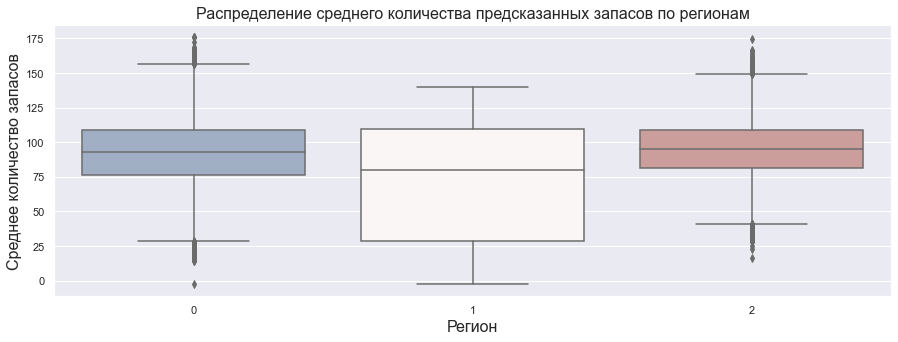

Средний потенциальный запас нулевого региона: 92.7 тыс. баррелей
Средний потенциальный запас первого региона: 69.29 тыс. баррелей
Средний потенциальный запас второго региона: 95.14 тыс. баррелей


In [24]:
sns.boxplot(data=[predicted_0, predicted_1, predicted_2], palette="vlag")

sns.set_style("darkgrid")

plt.title('Распределение среднего количества предсказанных запасов по регионам', size=16)
plt.xlabel('Регион', size=16)
plt.ylabel('Среднее количество запасов', size=16)

plt.show()

print('Средний потенциальный запас нулевого региона:', round(predicted_0.mean(),2), 'тыс. баррелей')
print('Средний потенциальный запас первого региона:', round(predicted_1.mean(),2), 'тыс. баррелей')
print('Средний потенциальный запас второго региона:', round(predicted_2.mean(),2), 'тыс. баррелей')

In [25]:
df_0 = pd.DataFrame(predicted_0)
df_1 = pd.DataFrame(predicted_1)
df_2 = pd.DataFrame(predicted_2)
df_0['region'] = 0
df_1['region'] = 1
df_2['region'] = 2
df = pd.concat([df_0, df_1, df_2]).reset_index(drop=True)
df.columns = ['reserve', 'region']

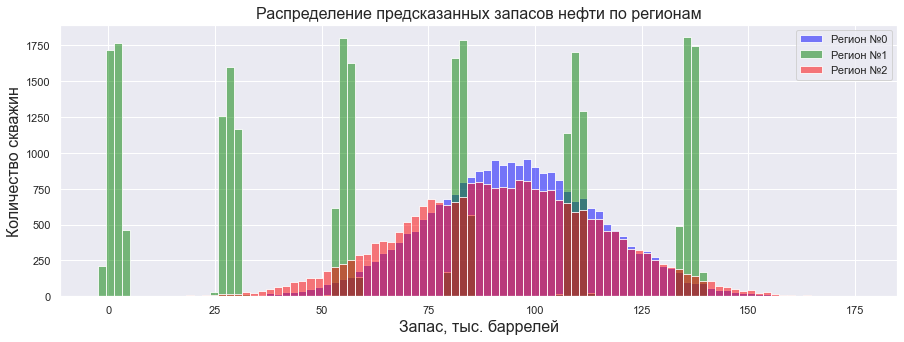

In [26]:
sns.histplot(df, x='reserve', hue='region', palette=['red', 'green', 'blue'])

plt.title('Распределение предсказанных запасов нефти по регионам', size=16)
plt.xlabel('Запас, тыс. баррелей', size=16)
plt.ylabel('Количество скважин', size=16)
plt.legend(['Регион №0', 'Регион №1', 'Регион №2'])

plt.show()

In [27]:
profit_0 = bootstrap_profit_simulation(y_0_valid, predicted_0)
profit_1 = bootstrap_profit_simulation(y_1_valid, predicted_1)
profit_2 = bootstrap_profit_simulation(y_2_valid, predicted_2)

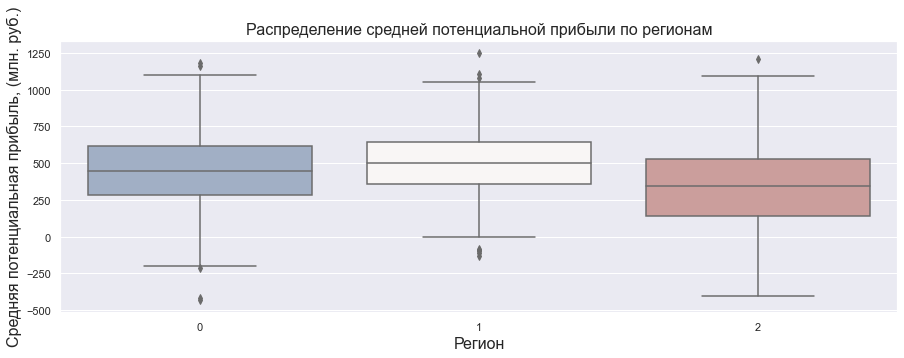

Средняя потенциальная прибыль нулевого региона: 448.59 (млн. руб.)
Средняя потенциальная прибыль первого региона: 498.14 (млн. руб.)
Средняя потенциальная прибыль второго региона: 339.33 (млн. руб.)


In [28]:
sns.boxplot(data=[profit_0, profit_1, profit_2], palette="vlag")

sns.set_style("darkgrid")

plt.title('Распределение средней потенциальной прибыли по регионам', size=16)
plt.xlabel('Регион', size=16)
plt.ylabel('Средняя потенциальная прибыль, (млн. руб.)', size=16)

plt.show()

print('Средняя потенциальная прибыль нулевого региона:', round(profit_0.mean(),2), '(млн. руб.)')
print('Средняя потенциальная прибыль первого региона:', round(profit_1.mean(),2), '(млн. руб.)')
print('Средняя потенциальная прибыль второго региона:', round(profit_2.mean(),2), '(млн. руб.)')

Второгой регион имеет меньший средний запас нефти в скважинах, но при этом алгоритм отбора 200 лучших скважин из 500 случайно выбранных продемонстрировал неоходимость определения наиболее прибыльных скважин региона. Таким образом, потенциальная прибыль второго региона значительно превосходит другие два, при этом риски убытка не превышают пороговое значение.

### Расчёт средней прибыли, доверительных интервалов и рисков

Создадим функцию, которая будет выводить всю необходимую информацию.

In [29]:
def show_info(region, profits_mean, conf_int_left, conf_int_right, loss_rate):
    print(region.center(40, '-'))
    print(f'Средняя прибыль: {profits_mean:.2f} (млн. руб.)')
    print(f'95% доверительный интервал: {conf_int_left:.2f} : {conf_int_right:.2f} (млн. руб.)')
    print(f'Вероятность получить убыток: {loss_rate:.2f} %')

А так же функцию расчёта требуемых параметров.

In [30]:
def stats_calc(profit_simulation, region): 
    """Функция принимает серию со значениями прибыли и название региона в формате строки.
    
    Рассчитывает 95% доверительный интервал
    Рассчитывает вероятность убытка
    Активирует функцию вывода статистики на экран
    
    """
    alpha = 0.05

    profits = pd.Series(profit_simulation)
    profits_mean = profits.mean()
    
    conf_int_left = profits.quantile(alpha/2)
    conf_int_right = profits.quantile(1 - alpha/2)
    
    loss_rate = (profits < 0).mean() * 100
    
    show_info(region, profits_mean, conf_int_left, conf_int_right, loss_rate)

In [31]:
stats_calc(profit_0, 'Регион №0')

---------------Регион №0----------------
Средняя прибыль: 448.59 (млн. руб.)
95% доверительный интервал: -59.16 : 931.84 (млн. руб.)
Вероятность получить убыток: 3.70 %


In [32]:
stats_calc(profit_1, 'Регион №1')

---------------Регион №1----------------
Средняя прибыль: 498.14 (млн. руб.)
95% доверительный интервал: 74.49 : 902.29 (млн. руб.)
Вероятность получить убыток: 0.70 %


In [33]:
stats_calc(profit_2, 'Регион №2')

---------------Регион №2----------------
Средняя прибыль: 339.33 (млн. руб.)
95% доверительный интервал: -202.40 : 857.48 (млн. руб.)
Вероятность получить убыток: 11.30 %


Вероятность получить убыток не превышает 2.5% только для региона №1, а также он обладает наибольшей потенциальной средней прибылью, следовательно, для разработки целесообразно взять именно его.

<a id='section_5'></a>
## Общий вывод

В ходе исследования были обработаны и проанализированы данные о регионах бурения скважин для добычи нефти. 
Были изучены данные о качетсве содержимого скважин, созданы модели предсказания объёма запасов нефти и рассчитаны потенциальная прибыль с рисками убытка, а также сделаны выводы и рекомендации. 

**После проделанного исследования можно сделать следующие выводы:**
1. Выявлена высокая корреляция праметра `f2` и целевого признакак `product` в регионе №1.
2. Создана модель, способная с высокой точностью определять запасы нефти в месторождениях региона №1.
3. Средний запас сырья в регионе №1 ниже, но за счёт использования алгоритма отбора лучших скважин выяснено, что он является наиболее перспективным с точки зрения потенциальной прибыли:
    - Средняя потенциальная прибыль первого региона: 448.59 (млн. руб.)
    - Средняя потенциальная прибыль второго региона: 498.14 (млн. руб.)
    - Средняя потенциальная прибыль третьего региона: 339.33 (млн. руб.)
4. Риски убытков от разработки месторождений не превышают 2.5% только в регионе №1:
    - Вероятность получить убыток для первого региона: 3.70 %
    - Вероятность получить убыток для второго региона: 0.70 %
    - Вероятность получить убыток для третьего региона: 11.30 %
**Рекомендации:**
1. Обратить внимание на наличие дубликатов скважин в данных.
2. Начинать разработку скважин в регионе №1.
3. Использовать модель предсказания объёма запасов нефти.